In [276]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sea
import numpy as np
import ryan_tools as rt

In [277]:
def get_data_from_review(review):

    def get_text(stars):
        text = stars.find_all(class_ = 'minor')
        result = []
        for t in text:
            result.append(t.text)
        return result

    def get_status_job(review):
        text = review.find_all(class_= 'authorJobTitle middle reviewer')[0].text
        if 'Former Employee - ' in text:
            status = 'Former Employee'
        if 'Current Employee - ' in text:
            status = 'Current Employee'
        job = text.replace('Former Employee - ', '').replace('Current Employee - ', '')
        return status, job
        
    
    def get_rating(stars):
        ratings = stars.find_all(class_ = 'gdBars gdRatings med ')
        result = []
        for rating in ratings:
            result.append(float(rating['title']))
        return result
    
    result = pd.Series()
    result['date'] = review.find_all('time')[0]['datetime']
    
    stars = review.find_all(class_ = 'gdStars gdRatings sm margRt')[0]
    text = get_text(stars)
    ratings = get_rating(stars)
    x = dict(zip(text, ratings))
    for key in x.keys():
        result[key] = x[key]

    status, job = get_status_job(review)
    result['job'] = job
    result['status'] = status
    return result


def get_reviews_from_page(page_request):
    data = pd.DataFrame()
    soup = BeautifulSoup(page_request.text, 'html.parser')
    
    for i, review in enumerate(soup.find_all(class_ = 'hreview')):
        review_data = get_data_from_review(review)
        for index in review_data.index:
            cols = data.columns
            if index not in cols:
                data[index] = None
        data.loc[i] = review_data
        
    data['date'] = pd.to_datetime(data['date'])
    return data.dropna()

In [278]:
def get_page(url):
    if not url.startswith('https://'):
        url = 'https://www.glassdoor.com' + url
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    return requests.get(url, headers = headers)

def get_next_page_url(page):
    soup = BeautifulSoup(page.text, 'html.parser')
    links = soup.find_all( class_ = 'next')[0]
    result = ''
    for link in links:
        result = link.get('href')
    return result

def get_all_pages(start_page):
    done = False
    pages = []
    while not done:
        current_page = get_page(start_page)
        pages.append(current_page)
        next_page = get_next_page_url(current_page)
        start_page = next_page
        if type(next_page) == type(None):
            done = True
            
    return pages

In [279]:
pages = get_all_pages('https://www.glassdoor.com/Reviews/AMD-Reviews-E15.htm')

In [375]:
def get_all_from_company(start = None, pages = None):
    if type(pages) == type(None):
        pages = get_all_pages(start)
    result = pd.DataFrame()
    bar = rt.progress_bar(len(pages))
    for page in pages:
        result = result.append(get_reviews_from_page(page))
        bar.progress()
    return result.sort_values('date').reset_index(drop = True)

In [409]:
amd = get_all_from_company(pages = pages)
amd.set_index('date',  inplace = True)
amd['layoff'] = (amd['status'] == 'Former Employee').astype(int)


0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o> | 100.00 % 
Done: 168 Remaining: 1, Remaining Time: 0s


In [413]:
def rename_cols(data):
    changes = {'Career Opportunities':'opps', 'Comp & Benefits':'comp', 
               'Culture & Values':'culture', 'Senior Management':'senior', 'Work/Life Balance':'balance'}
    data.rename(columns=changes, inplace=True)
    for thing in ['balance', 'culture', 'opps', 'comp', 'senior']:
        data[thing] = pd.to_numeric(data[thing])
rename_cols(amd)

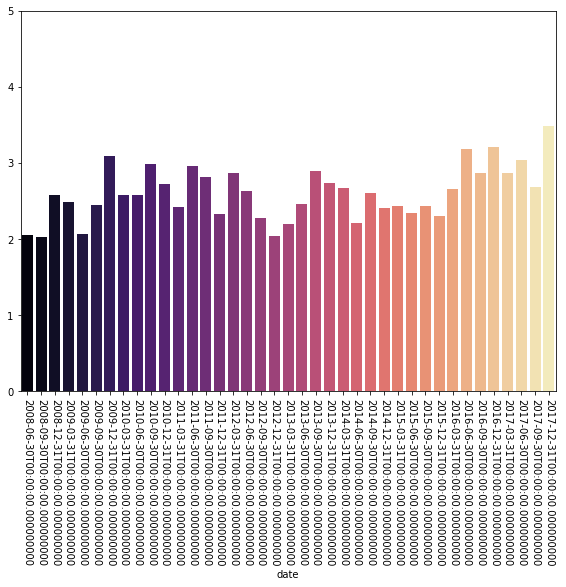

In [414]:
x = amd.copy()
x = x.groupby(pd.Grouper(freq = 'Q'))['senior'].mean()

x = x[x.index.year < 2018]

fig, ax = plt.subplots()
fig.set_size_inches(7 * 1.37, 7)
sea.barplot(x.index, x.values, ax = ax, palette = 'magma', estimator= np.mean)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90 * 3)
ax.set_ybound(upper = 5)
plt.show()

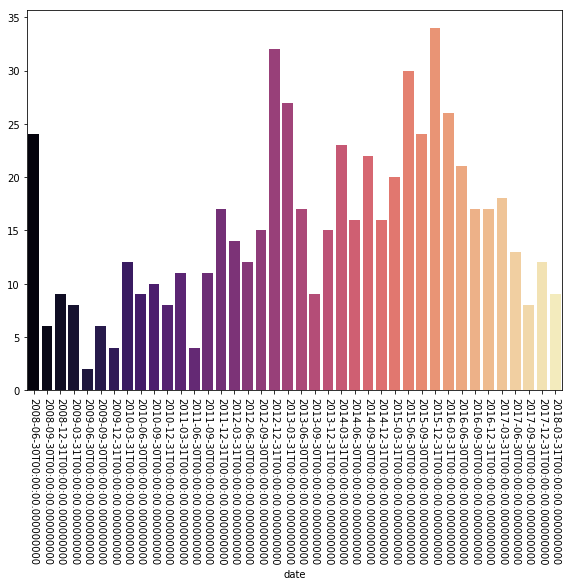

In [415]:
x = amd.groupby(pd.Grouper(freq = 'Q'))['layoff'].sum()

fig, ax = plt.subplots()
fig.set_size_inches(7 * 1.37, 7)
sea.barplot(x.index, x.values, ax = ax, palette = 'magma', estimator= np.mean)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90 * 3)

plt.show()